# Guassian mixture intra-song clustering for identification of "main" beats

Code for embedding and testing

In [66]:
import math, scipy
import numpy as np

# Tried to optimize bar embedding code but didn't finish
# Ideally, it takes in an array with number of divisions and does it all at once...
def bar_embedding_opt(data,dbeats,divisions,framerate,kernel=None, kernel_width=1/4):
    
    # Figure out the number of samples in a standard rescaled bar; make it a multiple of lcm of dimension
    n_bars = dbeats.shape[0]
    min_bar_samples = int((dbeats[1:] - dbeats[:-1]).min().item() * framerate)
    # Force an extra multiple of two because we subdivide by half
    dim_lcm = math.lcm(*list(divisions)) * 2
    assert dim_lcm < min_bar_samples, f'lcm {dim_lcm} must be smaller than smallest bar length {min_bar_samples}'
    new_samples = (min_bar_samples // dim_lcm) * dim_lcm
    print(new_samples)

    resampled_data = np.zeros(0)
    # Resample each bar to be uniform
    for i in range(dbeats.shape[0]):
        start = int(dbeats[i] * framerate)
        if i < dbeats.shape[0] - 1:
            end = int(dbeats[i+1] * framerate)
        else:
            end = data.shape[0]
        resampled_data = np.concatenate([resampled_data, scipy.signal.resample(data[start:end], new_samples)], axis=0)


    # Kernels for each division
    lens = []
    kernels = []
    for d in divisions:
        sub_beat_interval = new_samples // (d * 2)
        lens.append(sub_beat_interval)

        kernel_sigma = kernel_width * sub_beat_interval
        kernel = np.exp(-np.arange(-sub_beat_interval,sub_beat_interval,1)**2/(2*kernel_sigma**2))
        kernels.append(kernel / np.sum(kernel))

    outputs = [np.zeros(0) for _ in divisions]
    # Handle the first bar (edge case, half-cut off)
    for i, d in enumerate(divisions):
        outputs[i] = np.append(outputs[i], (kernels[i][-lens[i]:] * resampled_data[0:lens[i]]).sum())
        
    # Reshape the rest and apply kernel
    for i, d in enumerate(divisions):
        divided_data = resampled_data[lens[i]:-lens[i]].reshape(-1, 2 * lens[i])
        outputs[i] = np.append(outputs[i], (divided_data * kernels[i]).sum(axis=1))
        # Reshape the outputs to group by bar
        outputs[i] = outputs[i].reshape((-1, d))
        
    return outputs

In [ ]:
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks, get_beat_data, get_audio_data
#from groove.embedding import beat_frames_to_toy
import numpy as np
from groove.embedding import bar_embedding, load_bar_embedding, load_bar_embedding_total
import math

file = '06 Encore A'
ext= 'mp3'

load_bar_embedding_total('milaklaw', [2, 3], [1,1], smooth_power, concatenate=True).shape

# beat_data = get_beat_data(file)
# db = beat_data[beat_data[:,1] == 1, 0]
# _, proc, sr = get_audio_data(file, smooth_power, ext=ext)

# print("nbars", db.shape[0])

# data = bar_embedding_opt(proc, db, [2,3], sr)

# print(data[0].shape, data[1].shape)
# print(data)

#load_bar_embedding('06 Encore A', divisions=[2, 3], weights=[1, 1], process=smooth_power)

(180, 5)

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

def simulate_num_components(data, num_trials, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False):
    counts = {}
    for _ in range(num_trials):
        n_components = winnow_gm_components(data, confidence_limit=confidence_limit, cluster_threshold=cluster_threshold, overlap_allowance=overlap_allowance, use_weights=use_weights).means_.shape[0]
        if n_components in counts:
            counts[n_components] += 1
        else:
            counts[n_components] = 1
    return counts



from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from groove.intraclustering import get_ellipse_patch, get_patches, winnow_gm_components, ellipse_contains_points, find_closest_indices

def do_clustering(data, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False):
    gm = winnow_gm_components(data, confidence_limit=confidence_limit, cluster_threshold=cluster_threshold, overlap_allowance=overlap_allowance, use_weights=use_weights)
    print(f"Weights: {gm.weights_}")

    pca = PCA(n_components=2)
    pca.fit(data)
    print(f"PCA values: {pca.singular_values_}")

    return gm, pca

def do_projected_plot(gm, pca, data, confidence=0.9):

    red_data = pca.transform(data)
    patches, _ = get_patches(gm, confidence=confidence, pts=data, pca=pca)

    plt.figure()
    ax = plt.gca()
    ax.set_xlim([-.2, .2])
    ax.set_ylim([-.2, .2])


    plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
    for p in patches:
        ax.add_patch(p)

    return patches


from IPython.display import Audio
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
import librosa
from typing import Callable

def do_bar_sample(indices, file, process: Callable, ext="mp3"):
    raw_measures, proc_measures, sr = get_measures(file, process, ext)
    for i in indices:
        raw, proc = raw_measures[i], proc_measures[i]
        #beat_frames = get_beat_frames([proc], sr, beat_peaks)[0][0]
        #clicks = librosa.clicks(times=beat_frames/sr, length=raw.shape[0], sr=sr)


        plt.figure(figsize=(20, 4))
        #plt.plot(raw)
        plt.plot(proc)
        #plt.scatter(beat_frames, np.zeros(beat_frames.shape), marker='o', color='red', zorder=10)
        display(Audio(data=raw, rate=sr))
        #display(Audio(data=raw + clicks, rate=sr))


Load the file and process data using the embedding

In [102]:
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks, get_beat_data, get_audio_data
#from groove.embedding import beat_frames_to_toy
import numpy as np
from groove.embedding import bar_embedding, load_bar_embedding
import math

file = "milaklaw"
ext= "mp3"

#file = '03 All the Pretty Girls'
#ext = 'm4a'

#file = '09 D\'Angelo - Spanish Joint'
#ext = 'm4a'

#file = '06 Encore A'
#ext = 'mp3'

#file = 'lms'
#ext='mp3'

#data = load_bar_embedding('lms', smooth_power, 'mp3')

divs = np.array([3, 4, 6, 8, 9, 12, 16])
wts = 1/np.sqrt(divs)

#data_mk = load_bar_embedding('milaklaw', divisions=divs, weights=wts, process=smooth_power)
#data_e = load_bar_embedding('06 Encore A', divisions=divs, weights=wts, process=smooth_power)
#data = np.concatenate([data_mk, data_e], axis=0)

data = load_bar_embedding_total(file, divs, wts, smooth_power, ext=ext, concatenate=True)

Some rules for choosing the number of components:
1) Start with some number of components.
2) If overlaps between the 95%ile circles contain more than 10% of points, we should reduce.
3) If any circles don't cover 20%, we reduce.

First, run some simulations on the number of components.

In [ ]:
import pickle as pkl


# divs = np.array([3, 4, 6, 8, 9, 12, 16])
# wts = 1/np.sqrt(divs)

# data_mk = load_bar_embedding('milaklaw', divisions=divs, weights=wts, process=smooth_power)
# data_e = load_bar_embedding('06 Encore A', divisions=divs, weights=wts, process=smooth_power)
# data = np.concatenate([data_mk, data_e], axis=0)

# Test file took a long time to make so saving it for now
#with open("test1.pkl","wb+") as f:
#    pkl.dump(data, f)

# mk shape (179, 58)
# e shape (119, 58)

In [ ]:
simulate_num_components(data, 100)


# TODO: possible way to improve the alg: do some number of trials to determine number of components based on how "stable" it is, then run it for that number?
# TODO: or, pick the lowest that isn't an outlier?  lower tends to be better
# TODO: also, can take the average of the means?


{2: 100}

For visualization, PCA the top two components and project the clusters down

Weights: [0.61666666 0.38333334]
PCA values: [1.3429824  0.45727634]


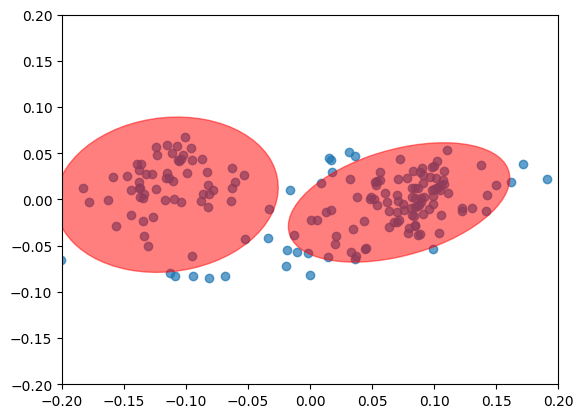

In [103]:
# pca = PCA(n_components=2)
# pca.fit(data)

# red_data = pca.transform(data)
c = .9

gm, pca = do_clustering(data, confidence_limit=c, cluster_threshold=0.3, overlap_allowance=0.1, use_weights=False)

# gm = GaussianMixture(n_components=2)
# gm.fit(data)
# pca = PCA(n_components=2)
# pca.fit(data)

do_projected_plot(gm, pca, data, c)
#(gm.means_ - pca.mean_) @ pca.components_.T




Pick the measures closest to the means of each cluster and play the audio.

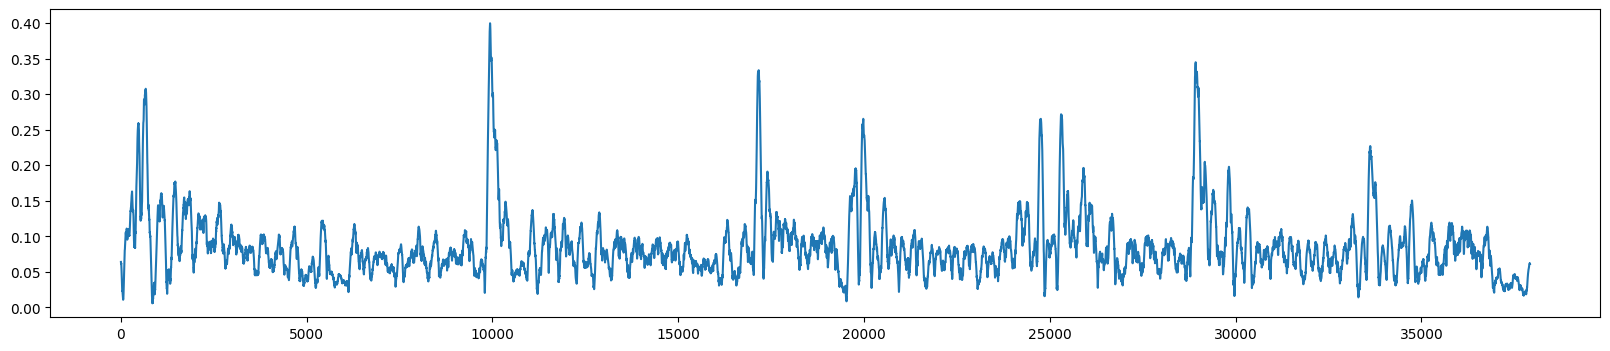

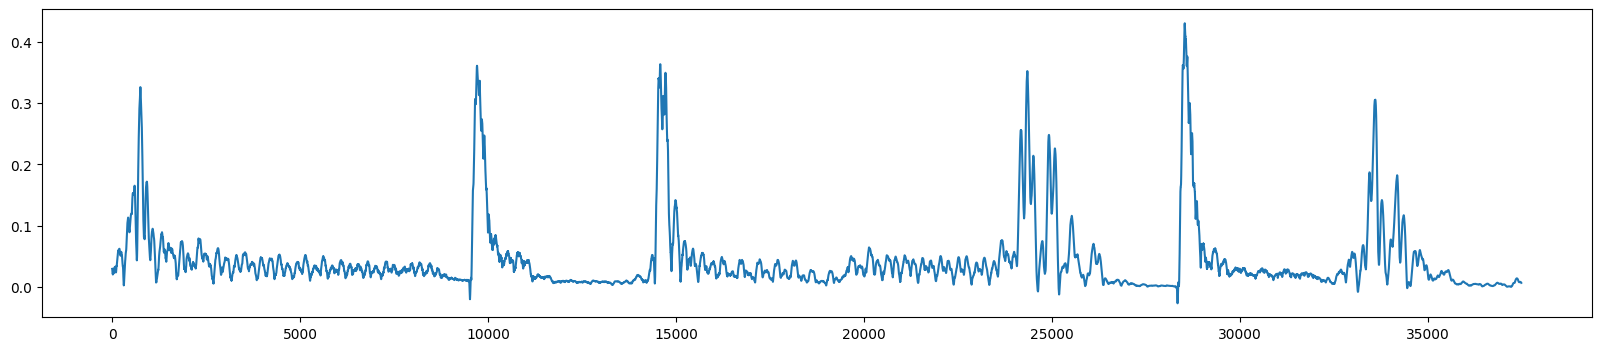

In [104]:
inds = find_closest_indices(gm.means_, data)
do_bar_sample(inds, file, smooth_power, ext)

In [79]:
inds = find_closest_indices(gm.means_, data)
print(inds)
do_bar_sample(inds[inds < data_mk.shape[0]], 'milaklaw', smooth_power)
do_bar_sample(inds[inds >= data_mk.shape[0]] - data_mk.shape[0], '06 Encore A', smooth_power)

[151  79 144   3]


NameError: name 'data_mk' is not defined